# M2 | Exploration Notebook

In this notebook, you will do a first exploration of the data set that you will use for your project. One part of this exploration is guided, i.e. we will ask you to solve specific questions (task 1-3). The other part is open, i.e. we will ask you to come up with your own exploration ideas (task 4). 

Please upload your solved notebook to Moodle (under Milestone 2 Submission)adding your SCIPER number in title, example: m2-lernnavi-456392.ipynb


## Brief overview of Lernnavi
[Lernnavi](https://www.lernnavi.ch) is an instrument for promoting part of the basic technical study skills in German and mathematics.


For the guided part of the exploration we will focus on the three main tables:
* *users*: demographic information of users.
* *events*: events done by the users in the platform.
* *transactions*: question and answer solved by user.

### Users
* user_id: unique identifier of user in database.
* gender: only three values: M male, F female or missing. 
* canton: swiss canton.
* class_level: school year in swiss system.


### Events
* event_id: unique identifier of event in database.
* user_id: user who peformed the event.
* timestamp: timestamp of event.
* category: classification of action (task, general, statistics, etc).
* action: type of action performed.
* event_type: whether the students viewed or clicked in the event.
* transaction_token: used to link to transactions table.
* session_id: session during which the event took place.
* tracking_data: optional content associated to this event (e.g., the new points mastered for a topic).


### Transactions
* transaction_id: unique identifier of transaction in database.
* transaction_token: used to link to events table.
* user_id: user who performed the transaction.
* document_id: document that was answered in transaction.
* document_version: version of document that was answered.
* evaluation: whether the user answered correctly or not. It is possible that it was only partially right. 
* input: answer the user gave.
* start_time: timestamp of when the user started answering.
* commit_time: timestamp of when the user submitted the answer.
* user_agent: the browser that the user used.
* validation: used to validate the format of the input.
* solution: solution to question.
* type: type of question that was answered. 


In [ ]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR = 'drive/MyDrive/MLBD_Lernnavi_Data' #You many change the directory

users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

## Task 1: Simple Statistics

In this task you are asked to do a first coarse exploration of the data set, using simple statistics and visualizations.

#### a) How many distinct participants do we have in the data set?


In [ ]:
print(f'Number is distinct participants is {len(events["user_id"].unique())}')

Number is distinct participants is 10113


#### b) How many transactions were done per user? Please provide a visualization and discuss the distribution.

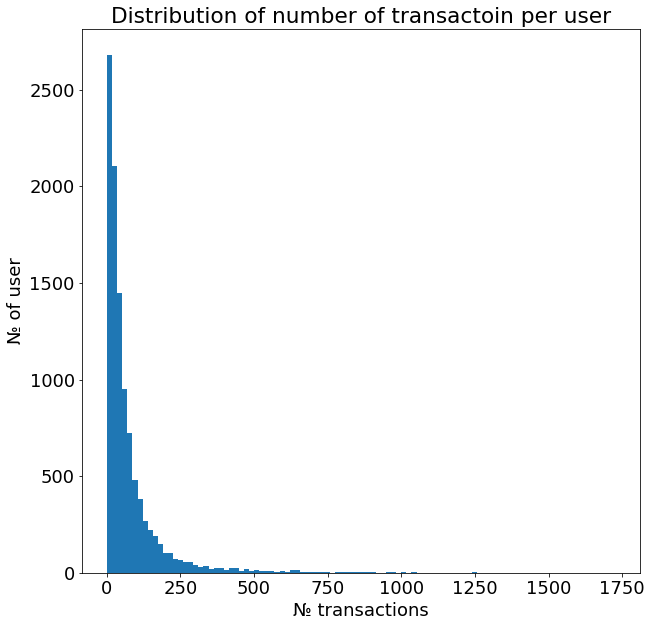

In [ ]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 18})
transaction_per_user = transactions.groupby('user_id')['transaction_id'].count().plot.hist(bins=100)
plt.xlabel('№ transactions')
plt.ylabel('№ of user')
plt.title('Distribution of number of transactoin per user')
plt.show()

According to the graph, the majority of number of transactions per user lays less than 250.

The distribution is very right skewed.

#### c) Which are the 10 most popular event actions? Please provide a visualization of the frequency of the top 10 event actions.

Hint: See actions in table events.

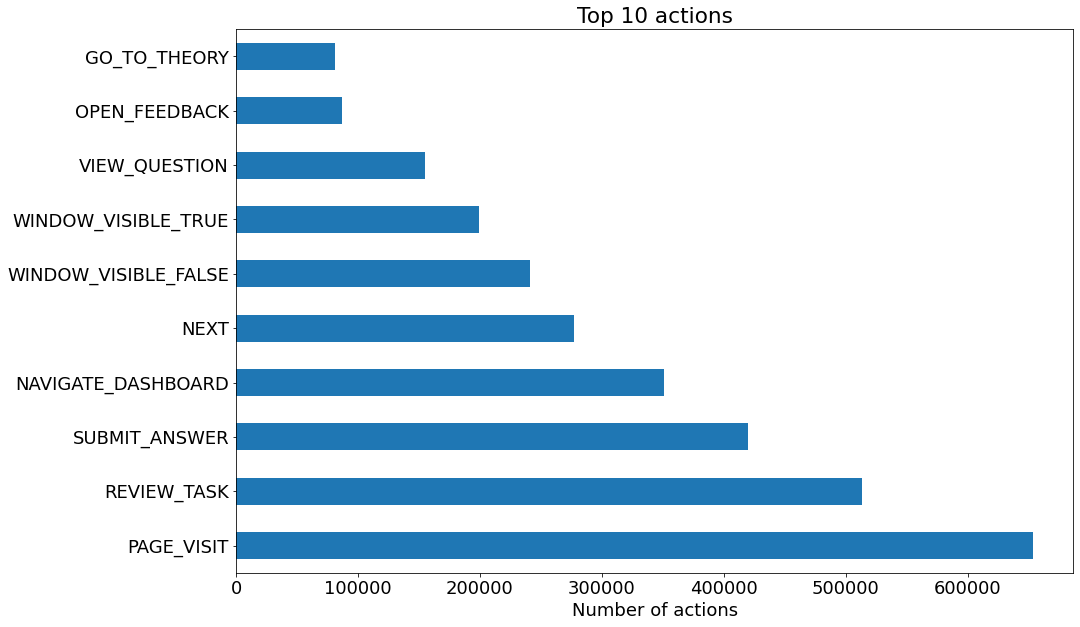

In [ ]:
plt.figure(figsize=(15,10))
events['action'].value_counts()[:10].plot.barh(y='Action', x='Amount')
plt.xlabel('Number of actions')
plt.title('Top 10 actions')
plt.rcParams.update({'font.size': 18})
plt.show()

The most popular action is "PAGE VISIT" and "REVIEW TASK"

## Task 2: Static Analysis

In this second task, you will do a univariate an multivariate exploration of some aggregated features.

#### a) Build a data frame containing one row per user:

``[user_id, gender, num_events, num_questions, percentage_correct, num_reading]``


The features are defined as follows:

- **num_questions**: total number of questions the student answered (hint: action event = submit answer)

- **num_events**: total number of events of the student  

- **percentage_correct**: number of correct answers/total number of answers (hint: evaluation = correct). If desired, you may assign a weight of 0.5 to partially correct answers. 

- **num_reading**: total number of theory reading events  (hint: action event = go to theory)

In [ ]:
# Your code for building the data frame here
df = users[['user_id', 'gender']].set_index('user_id')

In [ ]:
df = df.join(events.groupby('user_id')['event_id'].count().fillna(0))
df = df.join(events[events['action'] == 'SUBMIT_ANSWER'].groupby('user_id')['action'].count().fillna(0))
df = df.rename(columns={"event_id":"num_events", "action":"num_questions"})

df['percentage_correct'] = transactions[transactions['evaluation'] == 'CORRECT'].groupby('user_id')['evaluation'].count()  / transactions.groupby('user_id')['evaluation'].count() * 100
df['percentage_correct'] = df['percentage_correct']
df['num_reading'] = events[events['action'] == 'GO_TO_THEORY'].groupby('user_id')['action'].count()
df.dropna().head()

,gender,num_events,num_questions,percentage_correct,num_reading
user_id,,,,,
387615,MALE,492.0,15.0,56.756757,10.0
387666,MALE,368.0,34.0,42.352941,2.0
387674,MALE,304.0,39.0,59.615385,1.0
387685,MALE,89.0,12.0,40.740741,2.0
387710,MALE,396.0,18.0,55.882353,21.0


b) Perform a univariate analysis (including descriptive statistics and visualizations) for the five features (gender, num_events, num_questions, percentage_correct, num_reading) of your dataframe. Please check the lecture slides regarding information on how to perform a univariate analysis for categorical and numerical features. Discuss your results: how are the features distributed? Are there any anomalities?

In [ ]:
from scipy import stats

pd.set_option('precision', 2)

feature_list = [df['num_events'].fillna(0).to_numpy(), df['num_questions'].fillna(0).to_numpy(), df['percentage_correct'].fillna(0).to_numpy(),
       df['num_reading'].fillna(0).to_numpy()]

data = {'Mean': np.mean(feature_list,1),
        'Median':np.median(feature_list,1),
        'Mode': (stats.mode(feature_list,axis=1)[0])[:,0],
        'Variance':np.var(feature_list,1),
        'Std':np.std(feature_list,1),
        'Minimum': np.min(feature_list,1),
        '25%': np.percentile(feature_list, 25, axis=1),
        '75%': np.percentile(feature_list, 75, axis=1),
        'Maximum': np.max(feature_list,1)}

desc_stats_df = pd.DataFrame(data, index =['num_events', 'num_questions', 'percentage_correct', 'num_reading'])

display(desc_stats_df)

,Mean,Median,Mode,Variance,Std,Minimum,25%,75%,Maximum
num_events,253.05,103.00,0.0,268834.52,518.49,0.0,0.0,273.00,10044.0
num_questions,30.66,10.00,0.0,4650.63,68.20,0.0,0.0,32.00,1054.0
percentage_correct,34.85,38.71,0.0,771.29,27.77,0.0,0.0,55.19,100.0
num_reading,5.90,0.00,0.0,1039.71,32.24,0.0,0.0,2.00,2404.0


[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Gender')]

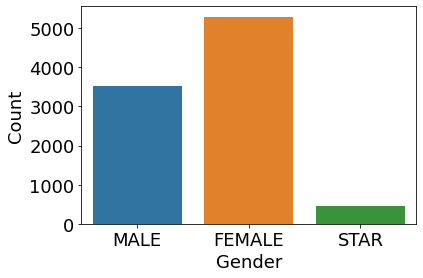

In [ ]:
import seaborn as sns
plt.rcParams.update({'font.size': 18})
gender = df.gender.value_counts(dropna=False)
pd.DataFrame({"Gender": gender.index, "Count": gender.tolist(), "Count %": gender.tolist()/np.sum(gender.tolist()) })

ax = sns.countplot(data=df, x= 'gender')
ax.set(xlabel='Gender', ylabel='Count')

Null hypothesis: data belong to norm distribution with param [34.85, 0.08]
p = 0, The null hypothesis can be rejected



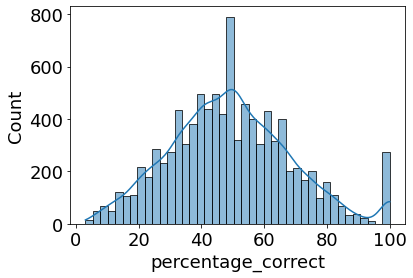

Null hypothesis: data belong to poisson distribution with param [253.05]
p = 0, The null hypothesis can be rejected

Null hypothesis: data belong to expon distribution with param [0.003951788184153329]
p = 0, The null hypothesis can be rejected



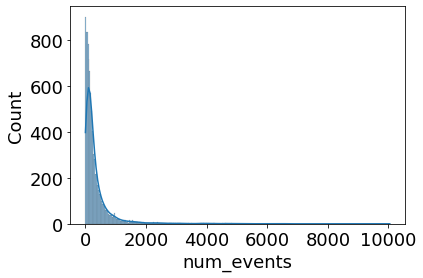

Null hypothesis: data belong to poisson distribution with param [30.66]
p = 0, The null hypothesis can be rejected

Null hypothesis: data belong to expon distribution with param [0.03261578604044357]
p = 0, The null hypothesis can be rejected



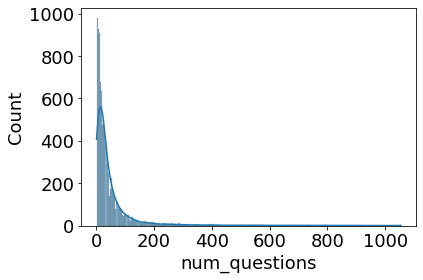

Null hypothesis: data belong to poisson distribution with param [5.9]
p = 0, The null hypothesis can be rejected

Null hypothesis: data belong to expon distribution with param [0.1694915254237288]
p = 0, The null hypothesis can be rejected



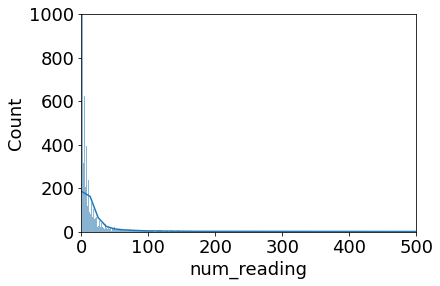

In [ ]:
from scipy.stats import skewnorm, chi2_contingency

def distr_test(data, disrt = 'norm', args = []):
    k2, p = stats.kstest(data, disrt, args = args)
    alpha = 0.01
    print(f'Null hypothesis: data belong to {disrt} distribution with param {args}')
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("p = {:g}, The null hypothesis can be rejected".format(p))
    else:
        print("p = {:g}, The null hypothesis cannot be rejected".format(p))
    print()




plt.rcParams.update({'font.size': 18})
distr_test(df.percentage_correct.dropna(), 'norm', args = [34.85, 0.08])
sns.histplot(data=df, x = 'percentage_correct', kde=True) 
plt.show()

plt.rcParams.update({'font.size': 18})
distr_test(df.num_events.dropna(), 'poisson', args = [253.05])
distr_test(df.num_events.dropna(), 'expon', args = [1/253.05])
sns.histplot(data=df, x = 'num_events', kde=True) 
plt.show()

plt.rcParams.update({'font.size': 18})
distr_test(df.num_questions.dropna(), 'poisson', args = [30.66])
distr_test(df.num_questions.dropna(), 'expon', args = [1/30.66])
sns.histplot(data=df, x = 'num_questions', kde=True) 
plt.show()

plt.rcParams.update({'font.size': 18})
distr_test(df[df['num_reading'] != 0].num_reading.dropna(), 'poisson', args = [5.90])
distr_test(df[df['num_reading'] != 0].num_reading.dropna(), 'expon', args = [1/5.90])
sns.histplot(data=df[df['num_reading'] != 0], x = 'num_reading', kde=True) 
plt.xlim(0, 500)
plt.ylim(0, 1000)
plt.show()

Unfortunately, the hypotheses that the distribution belongs to the normal, exponential or poisson were rejected. Most probably this happend because of outliers or wrong parametrs for distributions.

c) Come up with two additional features on your own and add them to the dataframe. Please provide an explanation/description of your features as well as an argument/hypothesis of why you think these features are interesting to explore.

In [ ]:
#Number of tasks
#Number of task can show  total volume of tasks
df['num_tasks'] = events[events['category'] == 'TASK'].groupby('user_id')['event_id'].count()
#average time for question
#Also,time for spending for an answer can be useful feature
transactions['diff_time'] = transactions['commit_time'] - transactions['start_time']
df['av_time'] = transactions.groupby('user_id')['diff_time'].mean()

*Your feature descriptions and arguments/hypotheses go here*

d) Perform a univariate analysis of your features (including descriptive statistics and visualization). What can you observe? Do the results confirm your hypotheses?

,Mean,Median,Mode,Variance,Std,Minimum,25%,75%,Maximum
num_tasks,6.30e+01,21.0,0.0,1.76e+04,1.33e+02,0.0,0.00,70.00,2.19e+03
av_time,1.52e+07,63516.4,0.0,1.87e+16,1.37e+08,0.0,3942.02,160451.01,6.56e+09


Null hypothesis: data belong to poisson distribution with param [94.7384193194292]
p = 0, The null hypothesis can be rejected

Null hypothesis: data belong to expon distribution with param [0.010555379825668227]
p = 0, The null hypothesis can be rejected



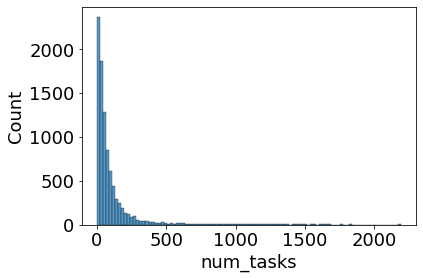

Null hypothesis: data belong to poisson distribution with param [20242768.935962427]
p = 0, The null hypothesis can be rejected

Null hypothesis: data belong to expon distribution with param [4.940035640200601e-08]
p = 0, The null hypothesis can be rejected



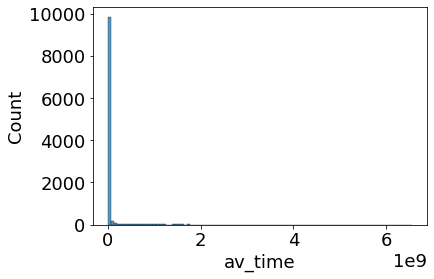

In [ ]:
feature_list = [df['num_tasks'].fillna(0), df['av_time'].fillna(0)]

data = {'Mean': np.mean(feature_list,1),
        'Median':np.median(feature_list,1),
        'Mode': (stats.mode(feature_list,axis=1)[0])[:,0],
        'Variance':np.var(feature_list,1),
        'Std':np.std(feature_list,1),
        'Minimum': np.min(feature_list,1),
        '25%': np.percentile(feature_list, 25, axis=1),
        '75%': np.percentile(feature_list, 75, axis=1),
        'Maximum': np.max(feature_list,1)}

desc_stats_df = pd.DataFrame(data, index =['num_tasks', 'av_time'])

display(desc_stats_df)

plt.rcParams.update({'font.size': 18})
distr_test(df.num_tasks.dropna(), 'poisson', args = [df['num_tasks'].mean()])
distr_test(df.num_tasks.dropna(), 'expon', args = [1/df['num_tasks'].mean()])
sns.histplot(data=df, x = 'num_tasks', bins = 100) 
plt.show()

plt.rcParams.update({'font.size': 18})
distr_test(df.av_time.dropna(), 'poisson', args = [df['av_time'].mean()])
distr_test(df.av_time.dropna(), 'expon', args = [1/df['av_time'].mean()])
sns.histplot(data=df, x = 'av_time',bins = 100) 
plt.show()

The same situation as for previous task. Distrutions still unknown.

e) Perform a multivariate analysis for two pairs of features of your choice. Please provide a metric and a visualization for both pairs. Please discuss: why did you choose these two pairs? What was your hypothesis? Do the results confirm your hypothesis?

 Correletaion for pair (av_time, num_reading) is (0.010870122586806679, 0.20337152168770983) 



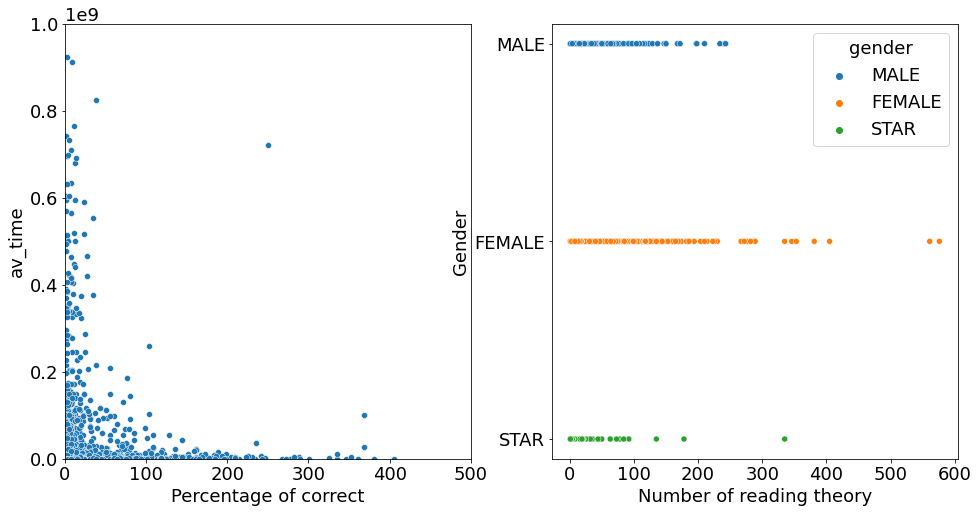

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,8))

plt.rcParams.update({'font.size': 18})
#f.figure(figsize=(16,8))
sns.scatterplot(data= df, y = 'av_time', x ='num_reading', ax = ax1)
ax1.set_xlim(0, 500)
ax1.set_ylim(0, 1*1e9)
ax1.set_xlabel("Percentage of correct")
ax1.set_ylabel("av_time")
# Correlation between variables (pairwise comparisonn)
r, p = stats.pearsonr(df['av_time'].fillna(0), df['num_reading'].fillna(0))
print(f' Correletaion for pair (av_time, num_reading) is {r, p} \n')




#plt.figure(figsize=(8,8))
sns.scatterplot(data= df.dropna(), x = 'num_reading', y ='gender', hue='gender', ax = ax2)
ax2.set_xlabel("Number of reading theory")
ax2.set_ylabel("Gender")
plt.show()


According to the graph can be concluded that Females read more theory than others. Also, there is a strange dependency between % of correct and average time. % of correct more for less average time. Most probably this people have already known this topics and they spent less time for think and were more confident in their answers.

# Task 3: Time-Series Analysis

In the last task, you will perform a time-series analysis.


#### a) Build a data frame containing one row per user per week:

``[user_id, week, num_events, num_questions, percentage_correct, num_reading]``


The features are defined as follows:

- **num_questions**: total number of questions the student answered **per week**(hint: action event = submit answer).

- **num_events**: total number of events of the student per week.

- **percentage_correct**: number of correct answers/total number of answers  **per week** (hint: evaluation = correct). If desired, you may assign a weight of 0.5 to partially correct answers.

- **num_reading**: total number of theory reading events **per week** (hint: action event = go to theory).

Where week 0 is the first week the specific user solved a task in the platform, i.e., the user's earliest entry in the transactions table.

Hint: You may extract the week of the year (dt.week) from the timestamps. 

You can limit the number of weeks to 13, i.e. for each user we just look at the first 13 weeks of data.
Yoy may change and justify your choice for the number of weeks.

In [ ]:
df = events[['user_id']]
min_timestamp_per_user = events.groupby(['user_id'])['timestamp'].min()

df = df.join(min_timestamp_per_user, on  = 'user_id', how='left')
df = df.rename(columns={"timestamp":"week"})
events['week'] = events['timestamp'] - df['week']
df['week'] = events['week'] 
#make limit for digits out of int
df = df[df['week'] < 9862400]

df['week'] = df['week'].apply(lambda x : pd.Timestamp(x, unit='s').week - 1)
#take only less than 14 weeks
df = df[df['week'] < 14]
events['week'] = events['week'].apply(lambda x : pd.Timestamp(x, unit='s').week - 1 if x < 7862400 else -1)



In [ ]:
# num_events
num_events = df.join(events['transaction_token']).join(transactions[transactions['evaluation'] == 'CORRECT'].groupby('transaction_token')['evaluation'].count(), on = 'transaction_token').groupby(['user_id', 'week'])['evaluation'].count()
df = df.join(num_events, on = ['user_id', 'week'])
# num_questions
num_questions = df.join(events[events['action'] == 'SUBMIT_ANSWER']['action']).groupby(['user_id', 'week']).count().fillna(0)['action']
df = df.join(num_questions, on = ['user_id', 'week'])
df = df.rename(columns={"evaluation":"num_events", "action" : "num_questions"})

df.set_index(['user_id', 'week'])

# percentage_correct
correct_per_week = events.join(transactions[transactions['evaluation'] == 'CORRECT'].groupby('transaction_token')['evaluation'].count(), on = 'transaction_token').groupby(['user_id', 'week'])['evaluation'].sum()
all_answers_per_week = events.join(transactions.groupby('transaction_token')['evaluation'].count(), on = 'transaction_token').groupby(['user_id', 'week'])['evaluation'].sum()
df = df.join(correct_per_week / all_answers_per_week * 100, on = ['user_id', 'week'])
# num_reading
num_reading = df.join(events[events['action'] == 'GO_TO_THEORY']['action']).groupby(['user_id', 'week']).count().fillna(0)['action']
df = df.join( num_reading, on = ['user_id', 'week'])
df = df.rename(columns={"evaluation":"percentage_correct", "action" : "num_reading"})

df.dropna().head()

,user_id,week,num_events,num_questions,percentage_correct,num_reading
43,390142,0,3,1,100.0,0
44,390142,0,3,1,100.0,0
46,390142,0,3,1,100.0,0
47,390137,0,0,0,0.0,0
48,390137,0,0,0,0.0,0


#### b) Select two features and analyze their behavior over time. Please provide a hypothesis and visualization for both features. For ideas on how to perform a time series exploration, please check the lecture slides and notebook. Discuss your results: what do you observe? Do the results confirm your hypotheses?

I selected two features "num_reading" and "num_questions". My hypothesis is that during the weeks people will read less theory (because students will know better subject) and  the number of  questions will increase for the first time and after stable constant (because users at the first time spend much more times for the new app and after their interest became a constant)

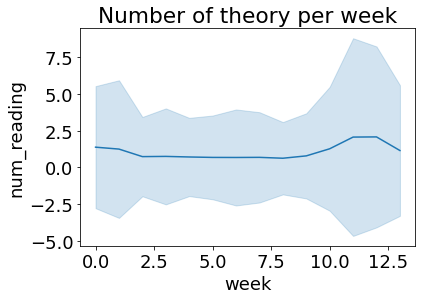

In [ ]:
ax = sns.lineplot(data=df, x="week", y="num_reading", ci='sd')
plt.title('Number of theory per week')
plt.rcParams.update({'font.size': 18})
plt.show()

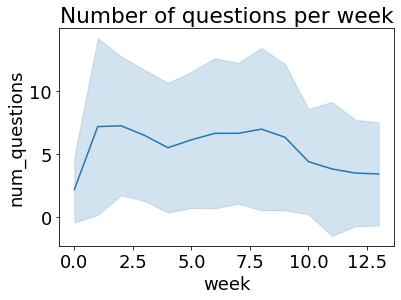

In [ ]:
ax = sns.lineplot(data=df, x="week", y="num_questions", ci='sd')
plt.title('Number of questions per week')
plt.rcParams.update({'font.size': 18})
plt.show()

Surprise, but the interest in the theory is similar for during all periods. It can be explained as that new questions require new knowledge.

Also on the graph  can be seen that in the first two weeks the number of questions increases, until the 8th week the number of questions remains high, then the number of questions decreases. This can be explained by the fact that perhaps in the first weeks the questions increase in complexity, but the questions after the 8th week may already be very complex, or users' interest in the resource decreases and they open fewer questions.

# Task 4: Creative extension 

Please provide **one** new hypothesis you would like to explore with the data and provide a visualization for it. Discuss your results: what do you observe? Do the results confirm your hypotheses?



I would like to explore differences for different genders. Ideally (for the assumption that all genders have equal behavior) there should not be big differences between % of correct answers.

I would like to observe behaviour for all genders for several features per week.


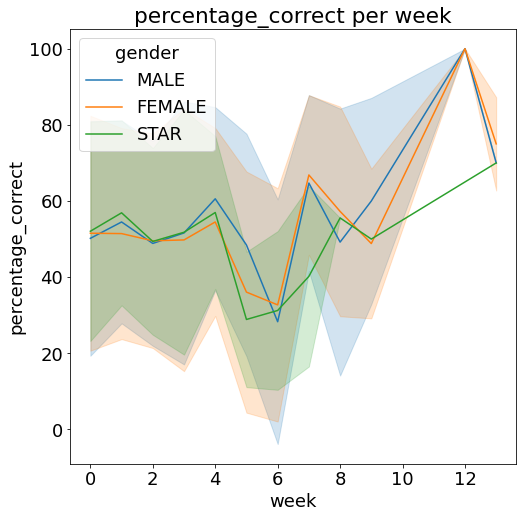

In [ ]:
plt.figure(figsize=(8,8))
df.set_index('user_id')
users.set_index('user_id')

plt.rcParams.update({'font.size': 18})
new_df = df.join(users['gender'])
ax = sns.lineplot(data=new_df, x="week", y="percentage_correct", ci='sd', hue = 'gender')
plt.title('percentage_correct per week')
plt.show()

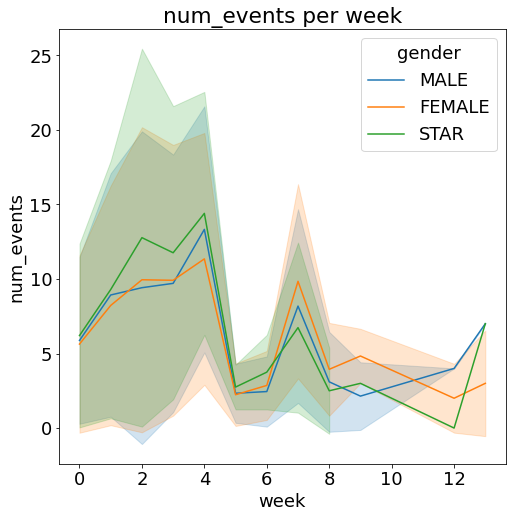

In [ ]:
plt.figure(figsize=(8,8))
df.set_index('user_id')
users.set_index('user_id')

plt.rcParams.update({'font.size': 18})
new_df = df.join(users['gender'])
ax = sns.lineplot(data=new_df, x="week", y="num_events", ci='sd', hue = 'gender')
plt.title('num_events per week')
plt.show()

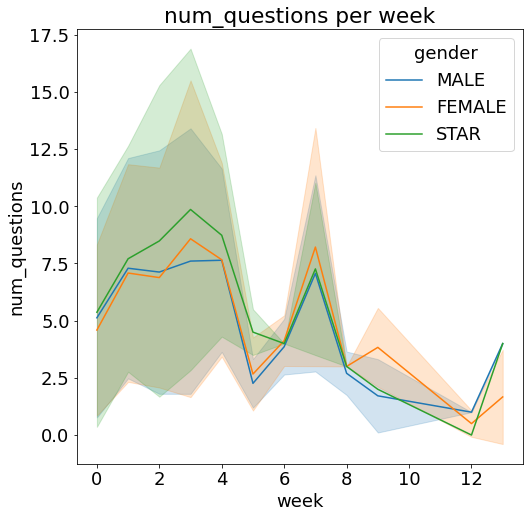

In [ ]:
plt.figure(figsize=(8,8))
df.set_index('user_id')
users.set_index('user_id')

plt.rcParams.update({'font.size': 18})
new_df = df.join(users['gender'])
ax = sns.lineplot(data=new_df, x="week", y="num_questions", ci='sd', hue = 'gender')
plt.title('num_questions per week')
plt.show()

The behavior of the graph is the same for both men and women.

As a result, my hypothesis that 100% of the correct answers for men and women are the same is not rejected.